# Configuring AuxTel FBS
March 2025.

## Overview

This notebook is intended to help to test configurations of the auxtel scheduler with the [ts_config_ocs/Scheduler/feature_scheduler/auxtel/fbs_spec_flex_survey.py](https://github.com/lsst-ts/ts_config_ocs/blob/develop/Scheduler/feature_scheduler/auxtel/fbs_spec_flex_survey.py) configuration.

It loads up the potential targets from the `auxtel_targets.yaml` file in `ts_config_os`, plots their airmass over the night (to help choose the best targets for a given night), then runs the `fbs_spec_flex_survey.py` configuration and shows the targets that would be chosen throughout the night, assuming that the observatory model is accurate and there are no interruptions due to faults or weather. The resulting airmass distribution of the simulated observations is plotted, and a few summary values (total number of observations, airmass range) counted up.

## FBS Configuration 

The basic idea in the configuration is that there are a variety of potential spectroscopy and imaging targets in [ts_fbs_utils/python/lsst/ts/fbs/utils/data/auxtel_targets.yaml](https://github.com/lsst-ts/ts_fbs_utils/blob/develop/python/lsst/ts/fbs/utils/data/auxtel_targets.yaml). For each entry, there is basic information on its location (ra/dec) and what JSON BLOCK should be used to observe the target (ideally a reusable, configurable JSON BLOCK, but not all are at that level yet). Along with this basic information, there are some additional entries which serve to help configure the FBS:
 * nexp - the number of visits in each sequence (aka how many times the JSON BLOCK should be run for each time this target hits the top of the FBS queue).
 * visit_gap - the amount of time to wait after the last visit in the sequence, before the target could be activated again
 * exptime - the amount of time to tell the FBS that each visit will take. For imaging this is straightforward (more or less exposure time), but for spectroscopy it should include the total time to run the imaging portions of the JSON BLOCK.
 * priority - a number to weight the reward functions for this target
 * ha_limits - there are default HA limits to avoid trying to observe near transit, but these can also be set per target in the yaml file. (this is to help avoid issues with the rotator angles during overslew, near transit in particular)

This configuration for auxtel imaging + spectroscopy is fairly simple -- each target matches a different survey (and sometimes two surveys, if it is both a priority and a backup target). And each survey has a fairly simple set of basis functions, which are primarily masks:
 * AvoidDirectWind - stay away from pointing into the wind, depending on the value of `wind_speed_maximum` (a large value for wind_speed_maximum will essentially turn this off)
 * MoonAvoidance - don't point closer than 30 degrees toward the moon. The size of the moon avoidance region could be modified, but this is the default.
 * AltAzShadowMask - this masks parts of the sky which are inaccessible. The default is to just mask below 26 degrees in altitude and above 85 degrees in altitude. There are more options available, if desired.
 * VisitGap - this causes the survey to count itself as unavailable after a sequence is acquired, until the `visit_gap` time (in minutes) has expired.
For some of the backup surveys, it may be desirable to include slew time basis functions .. but in general, the current setup makes it easy to cycle through a limited set of targets, simply by setting the visit_gap and priority appropriately.

For example, consider a scheduler set up with two targets, of equal priority, each with nexp = 4 and exptime = 300. Assume neither are close to the moon, get masked by wind, or fall into altitude avoidance zones, so at no point is either target unavailable (this, of course, will vary for real targets and conditions). In this case, IF there was no visit gap, random chance would pick one targets at the start of the night, take 4 visits each of exptime 300, and then after 1200 seconds (20 minutes), random chance would again pick between the two targets for a second 20 minutes, and on and on. Perhaps one target would 'win' the whole night, or perhaps it would vary. If one target was indicated to be a higher priority (`priority` set to 1.2 instead of the default 1), then that target would "win" for the entire night. However, if the goal was to cycle between these two targets every 20 minutes, then simply add a value for the `visit_gap` for each survey of about 15 minutes -- this would ensure that after a sequence was acquired for one target, the other target would be acquired next .. by the time the sequence for the second target is finished, the first target would be available again while the second was masked. The result would be alternating between the targets every twenty minutes. For a quicker alternation between targets, set a shorter sequence (nexp = 2 and visit_gap = 8 would result in about a 10 minute cadence,  etc). 

With more targets, this becomes more complicated, but an alternating series can be set up just using nexp, visit_gap, and exptime appropriately. Priority (especially combined with larger nexp or shorter visit_gap) can cause one target to be favored over the others, such as for a target chosen for more detailed study in a given night.

In addition, subsets of the total number of available targest in `auxtel_targets.yaml` can be chosen in the lists for `imaging_priority_targets`, `imaging_backup_targets`, `spectroscopy_priority_targets`, `spectroscopy_standard_targets` and `spectroscopy_backup_targets`. 
The imaging priority and spectroscopy priority targets are placed together in tier 1 (currently - could be modified to make these separate tiers), then spectroscopy_standard in tier2, then spectroscopy_backup goes into tier 3 and imaging_backup in tier 3. Tier 0 is the CWFS survey, set up to trigger every 2 hours on a point on the sky close to where observing is currently occuring. 

Remember that "tiers" of the FBS work like this: within a given tier, surveys are weighed against each other and whichever has the highest reward "wins" in that tier. However, the lowest tier will win against any survey in a higher tier -- if the tier 0 surveys *can* possibly execute, they will. Likewise, if tier 0 cannot, but tier 1 can - one of the tier 1 surveys will execute. A lower priority (larger number) tier will never execute if anything in a higher priority tier is viable. 

## Running this notebook

Technical setup requirements: `rubin_scheduler` must be installed, along with its data. You will also need `ts_fbs_utils` installed (a pip developer installation would be best), and a git clone of the `ts_config_ocs` repo.  
Short instructions for the full process, but note that some pieces can be skipped in some locations. 

* Install rubin_scheduler (you may want to make a new conda environment first) if needed. On the RSPs, `rubin_scheduler` is already installed, so you can skip this step. You want 3.4.0 or later, to match summit (hopefully soon 3.5.0). <br>
  ```conda install -c conda-forge rubin-scheduler```  <br> More details are available at the [installation instructions](https://rubin-scheduler.lsst.io/installation.html) if needed.
  
* Make sure the rubin_scheduler data is available. On the USDF RSP, setting <br> ```os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"``` <br>
will make the data available from a shared location. <br> In other locations (including other RSPs), follow the [data download instructions](https://rubin-scheduler.lsst.io/data-download.html#data-download) and add the environment variable to point to the download location. <br> ```export RUBIN_SIM_DATA_DIR="/my/preferred/data/path" <br> scheduler_download_data``` <br> For just the skybrightness files relevant to the current time, skip `rs_download_sky` and just download [60658-60871.h5](https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_skybrightness_pre/h5_2023_09_12/60658_60871.h5) into the `$RUBIN_SIM_DATA_DIR/skybrightness_pre` directory.

* Choose the location to save your copy of the `ts_fbs_utils` and `ts_config_ocs` repositories, then git clone both [ts_fbs_utils](https://github.com/lsst-ts/ts_fbs_utils) and [ts_config_ocs](https://github.com/lsst-ts/ts_config_ocs)

* Change into the `ts_fbs_utils` repository and ensure that your conda environment with rubin-scheduler is active, then: <br> ```pip install -e . --no-deps```

* Make a link to the FBS configuration file from the directory where you are running this notebook, so that it's easy to import. <br> ```ln -s ts_config_ocs/Schedulerfeature_scheduler/auxtel/fbs_spec_flex_survey.py .```

Edits to the auxtel_targets.yaml file in `ts_fbs_utils` or the FBS configuration file in `ts_config_ocs` should now be picked up whenever you restart the notebook, to explore different options for the configuration.

In [1]:
# Import the needed packages

import os
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet
from IPython.display import display, Markdown, HTML

from astropy.coordinates import SkyCoord, Angle
from astropy.time import Time, TimeDelta
import astropy.units as u
import astropy
astropy.utils.iers.conf.iers_degraded_accuracy = 'ignore'

from zoneinfo import ZoneInfo

timezone = "Chile/Continental"
tz = ZoneInfo(timezone)
tz_utc = ZoneInfo("UTC")

from astroplan import FixedTarget, Observer
from astroplan.plots import plot_airmass, plot_parallactic

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.scheduler.surveys import FieldSurvey
from rubin_scheduler.scheduler.example import get_ideal_model_observatory

from lsst.ts.fbs.utils.auxtel.surveys import get_auxtel_targets
from lsst.ts.fbs.utils import Target
import skyproj

# Import the 'get_scheduler' from the ts_config_ocs configuration file - ts_config_ocs/Scheduler/feature_scheduler/auxtel/<filename>
# Easiest way to import get_scheduler is to either link that file to your current directory, or run this notebook in that directory
from fbs_spec_flex_survey import get_scheduler

# If running on the USDF, find rubin_scheduler data here:
if "usdf" in os.getenv("EXTERNAL_INSTANCE_URL", ""):
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"

## Choose night for the simulation

In [2]:
# What night do you want to simulate? 
day_obs = '2025-03-13'
day_obs_mjd = int(Time(day_obs).mjd)
site = Site('LSST')
almanac = Almanac()
night_events = almanac.get_sunset_info(evening_date=day_obs, longitude=site.longitude_rad)
civil_sunset = Time(night_events['sunset'], format='mjd', scale='utc') 
sunset = Time(night_events['sun_n12_setting'], format='mjd', scale='utc') 
sunrise = Time(night_events['sun_n12_rising'], format='mjd', scale='utc')
survey_length = sunrise.mjd - sunset.mjd
night_length = sunrise.mjd - sunset.mjd

display(Markdown(f"## Almanac information for dayobs {day_obs}"))

display(Markdown(f"12-deg sunset at {sunset.to_datetime(timezone=tz_utc).strftime('%x %X')} UTC  -- {sunset.to_datetime(timezone=tz).strftime('%x %X')} {timezone}"))
display(Markdown(f"12-deg sunrise at {sunrise.to_datetime(timezone=tz_utc).strftime('%x %X')} UTC --  {sunrise.to_datetime(timezone=tz).strftime('%x %X')} {timezone}"))
display(Markdown(f"allowing for a night of {night_length * 24 :.2f} hours"))
moon_phase = almanac.get_sun_moon_positions(sunset.mjd)['moon_phase']
if not np.isnan(night_events['moonrise']):
    moonrise = Time(night_events['moonrise'], format='mjd', scale='utc')
    display(Markdown(f"Moonrise is at {moonrise.to_datetime(timezone=tz_utc).strftime('%x %X')} UTC -- {moonrise.to_datetime(timezone=tz).strftime('%x %X')} {timezone}"))
if not np.isnan(night_events['moonset']):
    moonset = Time(night_events['moonset'], format='mjd', scale='utc')
    display(Markdown(f"Moonset at {moonset.to_datetime(timezone=tz_utc).strftime('%x %X')} UTC -- {moonset.to_datetime(timezone=tz).strftime('%x %X')} {timezone}"))
display(Markdown(f"Moon phase is {moon_phase :.1f} (0=new, 100=full)."))
display(Markdown(f"Moon location at RA {Angle(almanac.get_sun_moon_positions(sunset.mjd)['moon_RA'][0] * u.rad).to_string(unit=u.hour, sep=':')}, "
                 f"Dec {Angle(almanac.get_sun_moon_positions(sunset.mjd)['moon_dec'] * u.rad).to_string(unit=u.degree, sep=':')}"))

## Almanac information for dayobs 2025-03-13

12-deg sunset at 03/13/25 23:54:03 UTC  -- 03/13/25 20:54:03 Chile/Continental

12-deg sunrise at 03/14/25 09:50:41 UTC --  03/14/25 06:50:41 Chile/Continental

allowing for a night of 9.94 hours

Moonrise is at 03/14/25 23:20:13 UTC -- 03/14/25 20:20:13 Chile/Continental

Moonset at 03/14/25 10:50:42 UTC -- 03/14/25 07:50:42 Chile/Continental

Moon phase is 98.3 (0=new, 100=full).

Moon location at RA 11:27:29.15638695, Dec 5:00:24.44462157

## Set up Scheduler

In [3]:
nside, scheduler = get_scheduler()

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/basis_functions/basis_functions.py:956: FutureWarning: filtername deprecated in favor of bandname
  warnings.warn("filtername deprecated in favor of bandname", FutureWarning)
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/basis_functions/basis_functions.py:1329: FutureWarning: filter_names deprecated in favor of band_names
  warnings.warn("filter_names deprecated in favor of band_names", FutureWarning)


In [4]:
# Collect target names as we do this ..
active_target_names = []

# Show some information about surveys and tiers
for ti, tier in enumerate(scheduler.survey_lists):
    print(f"\n TIER {ti}")
    for survey in tier:
        try:
            print(survey.survey_name, survey.ra, survey.dec, '// target',  survey.target_name, '// block',  survey.science_program, '// note', survey.scheduler_note)
            print('basis_functions', [bf.label() for bf in survey.basis_functions])
            print('seqlen', len(survey.observations), 'detailers',  [det.__class__.__name__ for det in survey.detailers])
            active_target_names.append(survey.target_name)
        except:
            print(survey.survey_name)
            print('basis_functions', [bf.label() for bf in survey.basis_functions])
            print('detailers', [det.__class__.__name__ for det in survey.detailers])

print("")
active_target_names = list(set(active_target_names))
print(f"Active survey targets: {active_target_names}")


 TIER 0
cwfs
basis_functions ['M5Diff r @4576006496', 'Slewtime g @6159600000', 'Slewtime r @6159063696', 'Slewtime i @6159065936', 'MoonAvoidance @6159605712', 'AltAzShadowMask @6159606048', 'VisitGap @6159604368', 'AvoidDirectWind @6159604704']
detailers ['ZeroRotDetailer', 'TrackingInfoDetailer']

 TIER 1
IMG:Photo08000-1 [2.13802833] [-0.63162981] // target Photo08000-1 // block BLOCK-306 // note IMG:Photo08000-1
basis_functions ['MoonAvoidance @6159068496', 'AltAzShadowMask @6159066576', 'VisitGap @6159069776', 'AvoidDirectWind @6159069456']
seqlen 8 detailers ['DitherDetailer', 'TrackingInfoDetailer']
CANDIDATE:HD132096 [3.92091853] [-0.69651145] // target HD132096 // block BLOCK-311 // note CANDIDATE:HD132096
basis_functions ['MoonAvoidance @6160353136', 'AltAzShadowMask @6160353440', 'VisitGap @6160353744', 'HourAngleLimit @6160336208']
seqlen 5 detailers ['TrackingInfoDetailer']

 TIER 2
CANDIDATE:HD111980 [3.37393961] [-0.32327376] // target HD111980 // block BLOCK-311 // no

## Get target pointing information

In [5]:
target_pointings = get_auxtel_targets('auxtel_targets.yaml')

targets = []
astroplan_targets = []
active_astroplan = []
for category in target_pointings:
    cat = category.split('_')[1].upper()
    for target_name in target_pointings[category]:
        tt = target_pointings[category][target_name]
        target = Target(
            target_name=target_name,
            survey_name=f"{cat}:{target_name}",
            science_program=tt["block"],
            ra=Angle(tt["ra"], unit=u.hourangle),
            dec=Angle(tt["dec"], unit=u.deg),
            hour_angle_limit=None,
            filters=["r"],
            visit_gap=tt.get("visit_gap", 5),
            exptime=tt.get("exptime", 300),
            nexp=1,
            reward_value=tt.get("priority", 1),
        )
        targets.append(target)

        # Make astroplan targets, for airmass plot
        atarget = FixedTarget(SkyCoord(ra=Angle(tt["ra"], unit=u.hourangle), dec=Angle(tt["dec"], unit=u.deg)), name=target_name)
        astroplan_targets.append(atarget)
        if target_name in active_target_names:
            active_astroplan.append(atarget)

In [6]:
# For easier copy-paste back into the fbs configuration file if needed
for category in target_pointings:
    print(category, list(target_pointings[category].keys()))

auxtel_candidate_catalog_targets ['HD36780', 'HD42525', 'HD60753', 'HD73495', 'HD111980', 'HD132096', 'HD146233', 'HD167060', 'HD205905', 'HD99685']
auxtel_standard_catalog_targets ['HD2811', 'HD38666', 'HD185975']
auxtel_imaging_targets ['Photo08000-1']


In [7]:
# Display target information for double-check on block/exptime/nexp/visit_gap/priority
dd = pd.concat([pd.DataFrame(target_pointings[category]).T for category in target_pointings])
dd.loc[active_target_names]

,ra,dec,block,exptime,nexp,visit_gap,priority,ha_limits
Photo08000-1,08:10:00,-36:11:23,BLOCK-306,35,8,600,1.5,NaN
HD132096,14:58:36.5,-39:54:25.8,BLOCK-311,420,5,20,1,NaN
HD185975,20:28:18,-87:28:19,BLOCK-311,420,1,90,1,NaN
HD111980,12:53:15,-18:31:20.0,BLOCK-311,420,5,15,1,"[[1.0, 23.0]]"


### Target Information throughout the night

2025-03-15 00:13:10.686


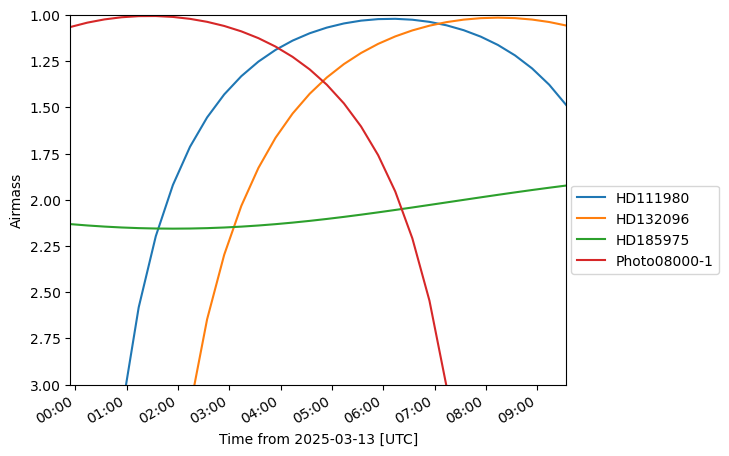

In [8]:
# Plot the airmass of these targets over the night
print(Time.now().iso)
observer = Observer(location=site.to_earth_location())
time = np.arange(sunset, sunrise, TimeDelta(20*60, format='sec'))
plot_airmass(active_astroplan, observer, time)
plt.legend(loc=(1.01, 0.3))

/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_21394/3585199526.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ = ax3.set_xticklabels(ax.get_xticks(), rotation = 45)


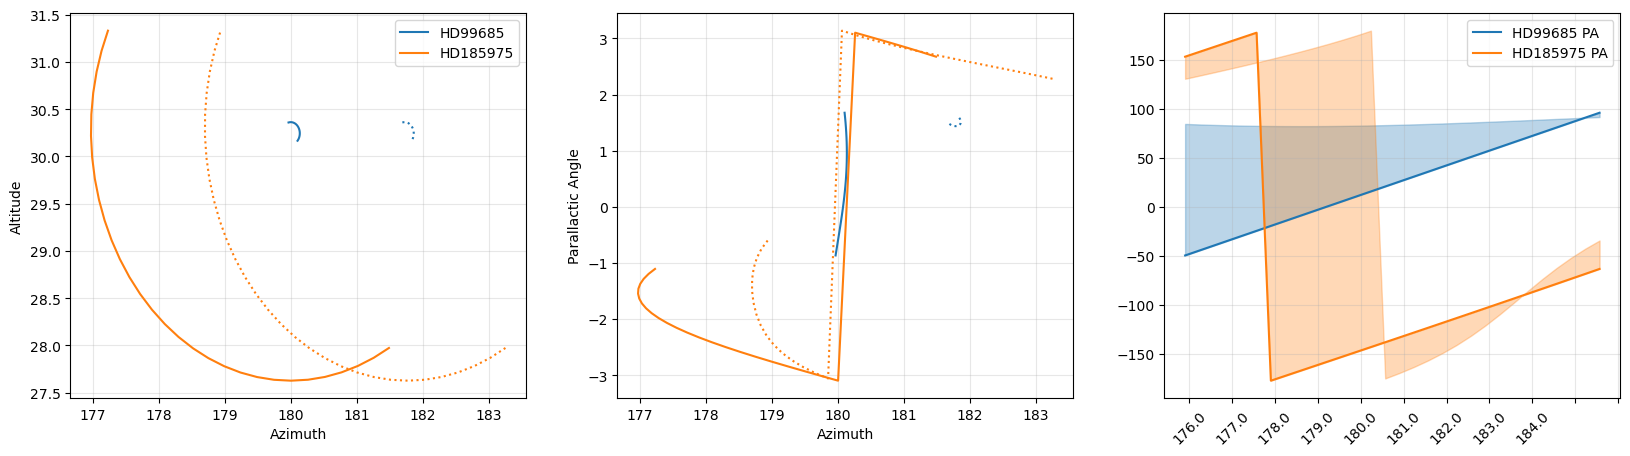

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(20, 5))

subset = active_astroplan
subset = [a for a in astroplan_targets if a.name in ["HD99685", "HD185975"]]
time_for_plot = np.array([t.datetime for t in time])
colors = colorcet.glasbey_category10

for i, atarget in enumerate(subset):
    if atarget.name.startswith("Photo"):
        continue
    ax = axes[0]
    ax2 = axes[1]
    ax3 = axes[2]
    altaz = observer.altaz(time, atarget)
    ax.plot(altaz.az, altaz.alt, color=colors[i], label=f"{atarget.name}")
    overslew_alt = altaz.alt
    overslew_az = altaz.az + Angle(2.0 * np.cos(altaz.alt.rad) * u.deg)
    ax.plot(overslew_az, overslew_alt, color=colors[i], linestyle=':')
    pa = observer.parallactic_angle(time, atarget)
    overslew_radec = SkyCoord(overslew_az, overslew_alt, frame=altaz).icrs
    overslew_pa = observer.parallactic_angle(time, overslew_radec)
    mask = np.where((altaz.alt.deg > 20) | (altaz.alt.deg > 85))
    ax2.plot(altaz.az[mask], pa[mask], color=colors[i], label=f"{atarget.name}")
    ax2.plot(overslew_az[mask], overslew_pa[mask], color=colors[i], linestyle=':')
    ax3.plot(time_for_plot[mask], pa[mask].deg, color=colors[i], label=f"{atarget.name} PA")
    ax3.fill_between(time_for_plot[mask], pa[mask].deg, overslew_pa[mask].deg, color=colors[i], alpha=0.3)
ax.legend()
ax3.legend()
ax.grid(alpha=0.3)
ax2.grid(alpha=0.3)
ax3.grid(alpha=0.3)
ax.set_ylabel("Altitude")
ax.set_xlabel("Azimuth")
ax2.set_ylabel("Parallactic Angle")
ax2.set_xlabel("Azimuth")
_ = ax3.set_xticklabels(ax.get_xticks(), rotation = 45)

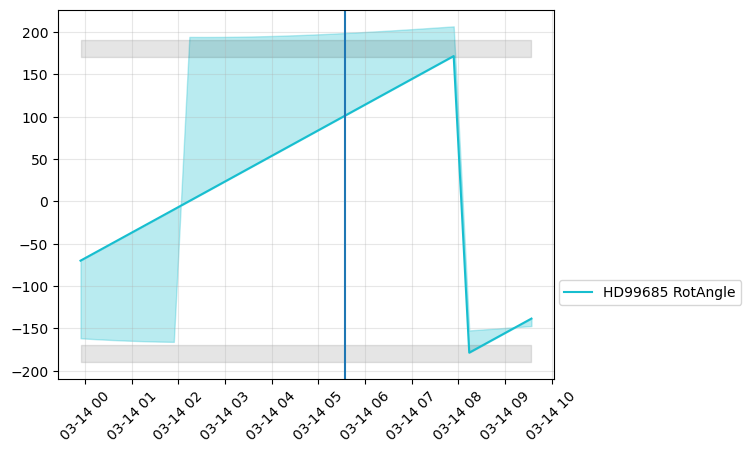

In [10]:
# Look at the parallactic angle alt/az ranges
time_for_plot = np.array([t.datetime for t in time])
colors = colorcet.glasbey_category10
mid_angle = Angle(180, unit=u.deg)
ninety = Angle(90, unit=u.deg)
for i, atarget in enumerate(astroplan_targets):
    if atarget.name in ["HD99685"]: # ["HD132096", "HD185975",  "HD111980"]: # "HD99685",] ["HD99685",]:#
        color = np.random.rand(3)
        altaz = observer.altaz(time, atarget)
        alt = altaz.alt.deg
        az = altaz.az.deg
        wrap_az = np.where(az <= 180, az, 360-az)
        pa = observer.parallactic_angle(time, atarget)
        # Update sky angle to be 90 degrees
        sky = (mid_angle + pa + Angle(90*u.deg) - altaz.alt).wrap_at(mid_angle)
        # Approximate rotator angle
        rot = (mid_angle + pa + sky - altaz.alt).wrap_at(mid_angle)
        #rot = (-pa + 2*altaz.alt + Angle(90*u.deg)).wrap_at(mid_angle)
        overslew_alt = altaz.alt
        overslew_az = altaz.az + Angle(2.0 * np.cos(altaz.alt.rad) * u.deg)
        overslew_radec = SkyCoord(overslew_az, overslew_alt, frame=altaz).icrs
        overslew_pa = observer.parallactic_angle(time, overslew_radec)
        overslew_sky = (mid_angle + overslew_pa + Angle(90*u.deg) - altaz.alt).wrap_at(mid_angle)
        overslew_rot = (mid_angle + overslew_pa + overslew_sky - altaz.alt)#.wrap_at(mid_angle)
        overslew_rot = np.where(rot.deg > 0, overslew_rot.wrap_at(Angle(360*u.deg)), overslew_rot.wrap_at(mid_angle))
        mask = np.where(alt > 20)
        color = colors[i]
        plt.plot(time_for_plot[mask], rot[mask].deg, color=color, linestyle='-', label=f"{atarget.name} RotAngle")
        #plt.plot(time_for_plot[mask], overslew_rot[mask].deg, color=color, linestyle='--')
        plt.fill_between(time_for_plot[mask], rot[mask].deg, overslew_rot[mask].deg, color=color, alpha=0.3)
        
plt.legend(loc=(1.01, 0.2))
plt.grid(alpha=0.3)
#plt.fill_between(time_for_plot, -10, 10, alpha=0.3)
plt.fill_between(time_for_plot, 170, 190, color='black', alpha=0.1)
plt.fill_between(time_for_plot, -170, -190, color='black', alpha=0.1)
plt.axvline(Time("2025-03-14 05:34", format='iso', scale='utc').datetime)
_ = plt.xticks(rotation=45)

In [11]:
def sky_to_rotator(sky_angle, par_angle, alt_az, nasmyth=True):
    # https://github.com/lsst-ts/ts_observatory_control/blob/3845a5ae7722e78aed1e4000132dc14884571991/python/lsst/ts/observatory/control/base_tcs.py#L578
    rot_tel = Angle(180.0, unit=u.deg) + par_angle + sky_angle
    if nasmyth:
        rot_tel -= alt_az.alt
    rot_tel = rot_tel.wrap_at(Angle(180.0, unit=u.deg))
    return rot_tel

### Run the simulation

In [12]:
# Note that the scheduler and observatory do need to be set up here - they change state as observations are requested and time moves on
# If you need to investigate the state of things at a particular point in the night, note the MJD of the failure, then set the sim_duration so that
# the simulation stops just at or prior to that point. 
# Then investigate the surveys and basis functions, using the conditions returned by the observatory at that time.

rewards = True 

obs_examples = []
for start_time in [sunset]:
    nside, scheduler=get_scheduler()
    scheduler.keep_rewards=rewards
    
    observatory = get_ideal_model_observatory(nside=nside, dayobs = day_obs, wind_speed=0, wind_direction=0)
    observatory.observatory.setup_camera(band_changetime=5.0, maxspeed=0.5, shutter_2motion_min_time=0.0)
    observatory.observatory.setup_telescope(altitude_maxspeed=1.5, azimuth_maxspeed=1.5, settle_time=40.0)
    observatory.observatory.setup_dome(azimuth_maxspeed=3.0)
    observatory.mjd = start_time.mjd

    # Catch the RuntimeWarning this particular setup is issuing due to calc_reward_function not expecting all nans
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", RuntimeWarning)
        vals = sim_runner(
            observatory,
            scheduler,
            sim_duration=survey_length,
            record_rewards=rewards,
            verbose=True,
        )
    observatory = vals[0]
    scheduler = vals[1]
    observations = vals[2]
    if len(vals) == 5:
        rewards = vals[3]
        obs_rewards = vals[4]
    obs_examples.append(observations)

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/basis_functions/basis_functions.py:956: FutureWarning: filtername deprecated in favor of bandname
  warnings.warn("filtername deprecated in favor of bandname", FutureWarning)
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/basis_functions/basis_functions.py:1329: FutureWarning: filter_names deprecated in favor of band_names
  warnings.warn("filter_names deprecated in favor of band_names", FutureWarning)
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")

progress = 21.83%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 32.21%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")


progress = 53.54%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Use

progress = 84.80%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")


Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 87 observations
ran in 0 min = 0.0 hours


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/utils/utils.py:179: UserWarning: IntRounded being used with a potentially too-small scale factor.
  warnings.warn("IntRounded being used with a potentially too-small scale factor.")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:359: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")


In [13]:
# If more debugging at a particular time is desired

# nside, scheduler = get_scheduler()
# observatory = get_ideal_model_observatory(nside=nside, dayobs = DAYOBS, wind_speed=0, wind_direction=0)
# observatory.observatory.setup_camera(band_changetime=5.0, maxspeed=1.5, shutter_2motion_min_time=0.0)
# observatory.observatory.setup_telescope(altitude_maxspeed=1.5, azimuth_maxspeed=1.5, settle_time=5.0)
# observatory.observatory.setup_dome(azimuth_maxspeed=3.0)
# observatory.mjd = sunset.mjd

# conditions = observatory.return_conditions()

# test_observations = []
# scheduler.update_conditions(conditions)
# obs = scheduler.request_observation(mjd=observatory.mjd, whole_queue=True)
# if obs is not None:
#     for o in obs:
#         observation, new_night = observatory.observe(o)
#         if observation is not None:
#             scheduler.add_observation(observation)
#             test_observations += [observation]

# Or look at survey basis functions at a particular time
# conditions = observatory.return_conditions()
# for ti, tier in enumerate(scheduler.survey_lists):
#     print(f"TIER {ti}")
#     for survey in tier:
#         print(survey.survey_name)
#         for bf in survey.basis_functions:
#             bf_values = bf(conditions)
#             if isinstance(bf_values, float):
#                 print(bf.label(), bf.check_feasibility(conditions), bf_values)
#             else:
#                 print(bf.label(), bf.check_feasibility(conditions), np.nanmax(bf_values[survey.roi_hpid]))
#         print('total survey reward', np.nanmax(survey.calc_reward_function(conditions)))

### Investigate the reward values throughout the night. 

The survey with the largest reward *in its tier* will be the "winner". Lower tiers will win over higher tiers.
Because the basis functions for most of the surveys are simply masks, these reward values will generally be flat across the night, with interruptions for visit gaps. Adjust the 'priority' to adjust the overall reward for a target up or down. 

/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_21394/1967778514.py:20: PerformanceWarning: indexing past lexsort depth may impact performance.
  s = survey_rewards_df.loc[index]


(60747.99587954022, 60748.41019899398)

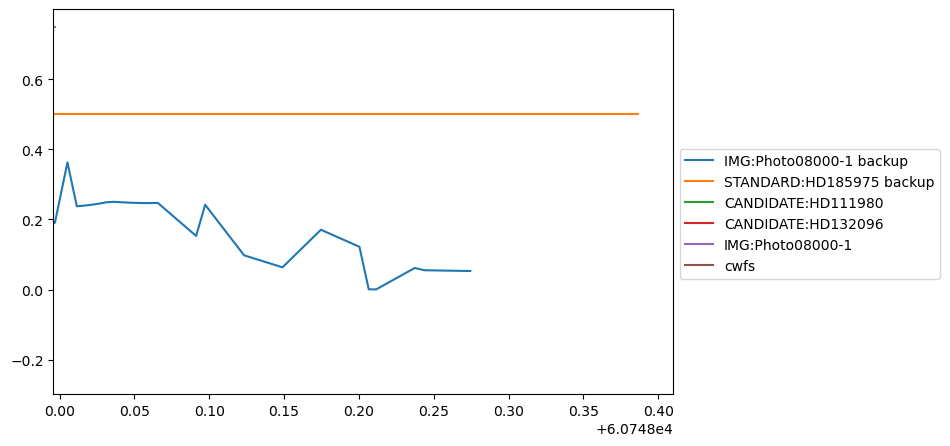

In [14]:
survey_rewards_df = (
        rewards.groupby(["list_index", "survey_index", "queue_start_mjd", "queue_fill_mjd_ns"])
        .agg(
            {
                "tier_label": "first",
                "survey_label": "first",
                "survey_class": "first",
                "survey_reward": "first",
                "feasible": "all",
            }
        )
        .loc[:, ["tier_label", "survey_label", "survey_class", "survey_reward", "feasible"]]
        .reset_index(level=["queue_start_mjd", "queue_fill_mjd_ns"])
        .query(f"floor(queue_start_mjd-0.5)=={day_obs_mjd}")
        .sort_index(ascending=False)
    )
plt.figure(figsize=(8, 5))

for index in survey_rewards_df.index.unique():
    s = survey_rewards_df.loc[index]
    plt.plot(s.queue_start_mjd.values, s.survey_reward.values, label=s['survey_label'].iloc[0])
plt.legend(loc=(1.01, 0.3))
plt.xlim(sunset.mjd, sunrise.mjd)

### Plot the airmass distribution of the observations per target

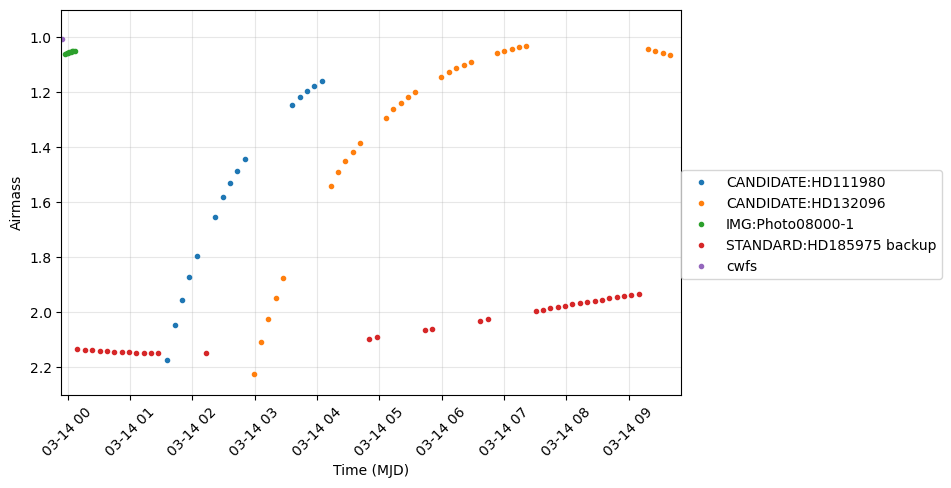

In [15]:
plt.figure(figsize=(8, 5))
for scheduler_note in np.unique(observations['scheduler_note']):
    match = np.where(observations['scheduler_note'] == scheduler_note)
    plt.plot(Time(observations[match]['mjd'], format='mjd', scale='utc').datetime, observations[match]['airmass'], marker='.', linestyle='', label=scheduler_note)
plt.xlim(sunset.datetime, sunrise.datetime)
plt.ylim(2.3, 0.9)
plt.legend(loc=(1.0, 0.3))
plt.xticks(rotation=45)
plt.xlabel("Time (MJD)")
plt.ylabel("Airmass")
plt.grid(alpha=0.3)

###  Some basic stats of the targets

In [16]:
obs = pd.DataFrame(observations)
# quick hack to get 'cwfs' into the target_name field for the CWFS survey, just for making this table look cleaner
cwfs_obs = np.where(obs['scheduler_note'] == "cwfs")[0]
target_col = np.where(obs.columns == "target_name")[0]
obs.iloc[cwfs_obs, target_col] = 'cwfs'

# Count up some basic stats about the airmass and number of observations
stats = obs.groupby('target_name').agg(min_airmass = ('airmass', 'min'), max_airmass = ('airmass', 'max'),
                                           airmass_range = ('airmass', np.ptp), timespan_hours = ('mjd', np.ptp), count=('mjd', 'count'))
stats['timespan_hours'] *= 24
stats = pd.merge(dd, stats, left_index=True, right_index=True, how='outer')
stats.sort_values(by='count', ascending=False)

,ra,dec,block,exptime,nexp,visit_gap,priority,ha_limits,min_airmass,max_airmass,airmass_range,timespan_hours,count
HD185975,20:28:18,-87:28:19,BLOCK-311,420,1,90,1,NaN,1.932881,2.149662,0.216781,9.002793,34.0
HD132096,14:58:36.5,-39:54:25.8,BLOCK-311,420,5,20,1,NaN,1.031812,2.226267,1.194454,6.679486,29.0
HD111980,12:53:15,-18:31:20.0,BLOCK-311,420,5,15,1,"[[1.0, 23.0]]",1.159289,2.173207,1.013918,2.471562,15.0
Photo08000-1,08:10:00,-36:11:23,BLOCK-306,35,8,600,1.5,NaN,1.048851,1.062410,0.013559,0.148583,8.0
cwfs,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.008609,1.008609,0.000000,0.000000,1.0
HD146233,16:15:37,-08:22:10.0,BLOCK-312,300,2,20,1,NaN,NaN,NaN,NaN,NaN,NaN
HD167060,18:17:44,-61:42:31.6,BLOCK-311,420,2,20,1,NaN,NaN,NaN,NaN,NaN,NaN
HD205905,21:39:10,-27:18:23.7,BLOCK-312,300,2,15,1,NaN,NaN,NaN,NaN,NaN,NaN
HD2811,00:31:18,-43:36:23.0,BLOCK-311,420,5,20,1,NaN,NaN,NaN,NaN,NaN,NaN
HD36780,05:34:04.0,-01:28:12.9,BLOCK-312,300,2,8,1,NaN,NaN,NaN,NaN,NaN,NaN


If this looks reasonable - then let's try this configuration. 
However, you may want to change the targets on a particular night -- go to the `ts_config_ocs/Scheduler/auxtel/fbs_spec_flex_survey.py` file (in your copy of the repo) and edit the lists of targets (spectropy_priority_targets and imaging_priority_targets, most likely). 
See if it starts doing what you want, and please come ask me more questions! 


In [17]:
# If you want a view that is the same as the Opsim output format .. (and quantities in degrees) .. 
from rubin_scheduler.scheduler.utils import SchemaConverter
visits = SchemaConverter().obs2opsim(observations)
visits = pd.DataFrame(visits)
visits['HA'] = (visits['fieldRA'] - visits['observationStartLST']) / 360 * 12 % 24
visits[['observationStartMJD', 'fieldRA', 'fieldDec', 'altitude', 'azimuth', 'target_name', 'science_program', 'airmass', 'visitExposureTime', 'slewTime', 'HA', 'paraAngle']]

,observationStartMJD,fieldRA,fieldDec,altitude,azimuth,target_name,science_program,airmass,visitExposureTime,slewTime,HA,paraAngle
0,60747.996385,100.310771,-22.777725,82.516487,6.523548,None,BLOCK-305,1.008609,30.0,43.679333,0.016632,186.111926
1,60747.998604,122.554238,-36.159018,70.438565,113.750442,Photo08000-1,BLOCK-306,1.062410,35.0,150.527519,0.731379,281.383974
2,60747.999489,122.560925,-36.190501,70.679368,113.995397,Photo08000-1,BLOCK-306,1.058458,35.0,40.469762,0.720952,281.799951
3,60748.000371,122.555987,-36.188417,70.934798,114.153579,Photo08000-1,BLOCK-306,1.056827,35.0,40.214785,0.710173,282.140580
4,60748.001257,122.531842,-36.228871,71.196975,114.458454,Photo08000-1,BLOCK-306,1.055193,35.0,40.538926,0.698708,282.632545
...,...,...,...,...,...,...,...,...,...,...,...,...
82,60748.381722,307.075000,-87.471944,31.082211,177.110568,HD185975,BLOCK-311,1.932881,420.0,4.332284,2.272065,287.887637
83,60748.387880,224.652083,-39.907167,73.770706,228.732074,HD132096,BLOCK-311,1.041582,420.0,111.056323,23.450535,57.963169
84,60748.392858,224.652083,-39.907167,72.582463,231.131609,HD132096,BLOCK-311,1.049863,420.0,9.093025,23.390636,61.415142
85,60748.397808,224.652083,-39.907167,71.363625,233.142654,HD132096,BLOCK-311,1.057428,420.0,6.684682,23.331073,64.476107


## Compare to actual visits acquired (or being acquired)

In [18]:
# Plot actual visits on top -- some things to import first .. 

from lsst_efd_client import EfdClient
import requests

# If it's in progress, we can also look at current visits - 
# On the RSP, access token available from lsst.rsp
try:
    from lsst.rsp import get_access_token
# But otherwise ..
except ImportError:
    def get_access_token(token_file : str | None = None) -> str:
        if token_file is not None:
            with open(token_file, "r") as f:
                token = f.read()
                token = token.rstrip("\n")
        else:
            token = os.environ.get("ACCESS_TOKEN")
        if token is None:
            warnings.warn("No RSP token available.")
        return token

def get_clients(token_file : str | None = None) -> dict:
    """Return site-specific client connections. 

    Parameters
    ----------
    token_file : `str` or None
        File containing an RSP token.

    Returns
    -------
    endpoints : `dict`
        Dictionary with `efd`, `obsenv`, 
        `narrative_log`, and `exposure_log`
        connection information.
        For the obsenv, narrative log and exposure log, these are only
        defined for the summit or USDF.

    Note
    ----
    The authentication token required to access the log services
    is an RSP token, and is RSP site-specific. 
    For users outside the RSP, a token can be created as described in
    https://nb.lsst.io/environment/tokens.html
    """
    # Set up authentication
    token = get_access_token(token_file)
    auth = ("user", token)
    # This authentication is for nightlog, exposurelog, nightreport currently
    # But I think it's the same underlying info for EfdClient i.e.
    # https://github.com/lsst/schedview/blob/e11fbd51ee5e22d11fef9a52f66dfcc082181cb6/schedview/app/scheduler_dashboard/influxdb_client.py
    # For lots more information on rubin tokens see DMTN-234.
    # For information on scopes, see DMTN-235.
    
    # let's do this like lsst.summit.utils.getSite but simpler
    site = "UNKNOWN"
    location = os.getenv("EXTERNAL_INSTANCE_URL", "")
    if "tucson-teststand" in location:
        site = "tucson"
    elif "summit-lsp" in location:
        site = "summit"
    elif "base-lsp" in location:
        site = "base"
    elif "usdf-rsp" in location:
        site = "usdf"
    # If location not set, next step is to check hostname
    elif location == "":
        hostname = os.getenv("HOSTNAME", "")
        interactiveNodes = ("sdfrome", "sdfiana")
        if hostname.startswith(interactiveNodes):
            site = "usdf"
        elif hostname == "htcondor.ls.lsst.org":
            site = "base"
        elif hostname == "htcondor.cp.lsst.org":
            site = "summit"

    
    if site == "summit":
        api_base = "https://summit-lsp.lsst.codes"
        efd_client = EfdClient("summit_efd")
        obsenv_client = EfdClient("summit_efd", db_name="lsst.obsenv")
    elif site == "tucson":
        api_base = None
        efd_client = EfdClient("tucson_teststand_efd")
        obsenv_client = EfdClient("tucson_teststand_efd", db_name="lsst.obsenv")
    elif site == "base":
        api_base = "https://base-lsp.slac.lsst.codes"
        efd_client = EfdClient("base_efd")
        obsenv_client = EfdClient("base_efd", db_name="lsst.obsenv")
    elif site == "usdf":
        # For tokens, need to distinguish between dev and prod
        if "dev" in location:
            api_base = "https://usdf-rsp-dev.slac.stanford.edu"
        else:
            api_base = "https://usdf-rsp.slac.stanford.edu"
        efd_client = EfdClient("usdf_efd")
        obsenv_client = EfdClient("usdf_efd", db_name='lsst.obsenv')
        # Also set up some env variables.
        os.environ["no_proxy"] += ",.consdb"
        os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/data/rubin/shared/rubin_sim_data"
    else:
        # Assume USDF prod (for any UNKNOWN)
        efd_client = EfdClient("usdf_efd")
        obsenv_client = EfdClient("usdf_efd", db_name='lsst.obsenv')
        api_base = "https://usdf-rsp.slac.stanford.edu"
    
    narrative_log =  "/narrativelog/messages"
    exposure_log = "/exposurelog/messages"
    nightreport =  "/nightreport/reports"
    consdb_query = "/consdb/query"
    
    endpoints = {'api_base': api_base, 'auth': auth, 
                'efd': efd_client, 'obsenv': obsenv_client, 
                'consdb': consdb_query,
                'narrative_log': narrative_log, 'exposure_log': exposure_log,  
                'nightreport': nightreport}
    
    # If some verbose output is desired
    # We'll put this here to make it easier to avoid printing the auth token
    endpoints_string = f"base url: {endpoints['api_base']} " 
    endpoints_string += f"efd host: {endpoints['efd'].influx_client.host}"
    endpoints['string'] = endpoints_string

    return endpoints


def query_logging_services(endpoint: str, auth: tuple, params: dict) -> pd.DataFrame:
    """Send `get` query to logging services. 
    
    Parameters
    ----------
    endpoint : `str`
        The URL to send the query to.
        Usually like `https://usdf-rsp.slac.stanford.edu/narrativelog/messages`
    auth : `tuple`
        The username and password for authentication.
        The username can be any string, the password should be an RSP token.
        See e.g. https://nb.lsst.io/environment/tokens.html 
    params : `dict`
        Dictionary of parameters for the REST API query.
        See docs for each service for more details.

    Returns
    -------
    messages : `pd.DataFrame`
        The returned log messages (if any available), in a dataframe.
    """
    # Very often, requests from the logging endpoints fail the first time.
    response = requests.get(endpoint, auth=auth, params=params)
    # Try twice.
    if response.status_code != 200:
        response = requests.get(endpoint, auth=auth, params=params)
    if response.status_code != 200:
        err_string = f"{endpoint} "
        err_string += " unavailable."
        print(response)
        print(err_string)
        messages = []
    else:
        messages = response.json()
    messages = pd.DataFrame(messages)
    return messages

def query_consdb(endpoint: str, auth: tuple, params: dict) -> pd.DataFrame:
    """Send `post` query to consdb.
    
    Parameters
    ----------
    endpoint : `str`
        The URL to send the query to.
        Usually like `https://usdf-rsp.slac.stanford.edu/consdb/query`
    auth : `tuple`
        The username and password for authentication.
        The username can be any string, the password should be an RSP token.
        See e.g. https://nb.lsst.io/environment/tokens.html 
    params : `dict`
        Dictionary of parameters for the REST API query.
        See docs for each service for more details.

    Returns
    -------
    messages : `pd.DataFrame`
        The returned visits information (if any available), in a dataframe.
    """
    # Very often, requests from the logging endpoints fail the first time.
    response = requests.post(endpoint, auth=auth, json=params)
    # Try twice.
    if response.status_code != 200:
        response = requests.post(endpoint, auth=auth, json=params)
    if response.status_code != 200:        
        print(endpoint, response)
        print(response.text)
        messages = []
    else:
        messages = response.json()
    if len(messages) > 0:
        messages = pd.DataFrame(messages['data'], columns=messages['columns'])
    return messages

retrieved 503 non-calib visits


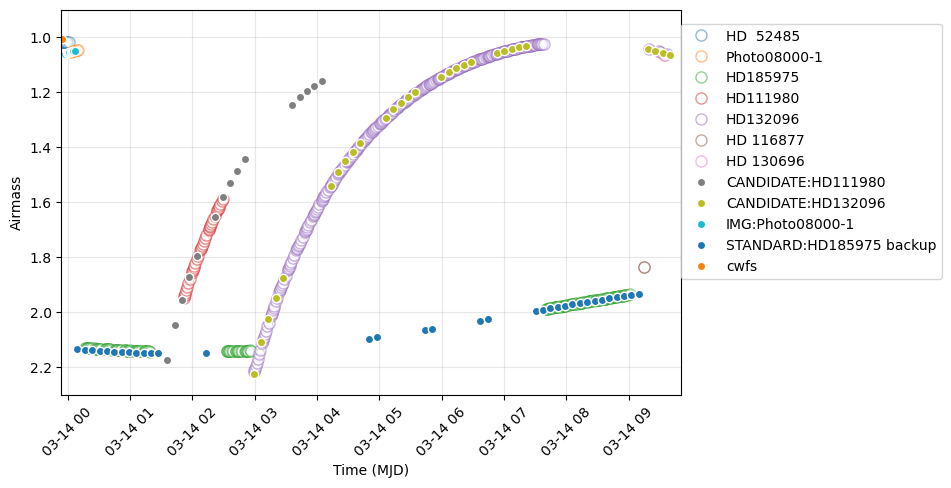

In [19]:
# Connect and retrieve visits from the consdb - replace the token file with your own token
endpoints = get_clients(token_file = '/Users/lynnej/.lsst/rsp_prod')
dayobsint = int(day_obs.replace('-', ''))
instrument = 'latiss'
query = f"select * from cdb_{instrument}.visit1 where day_obs = {dayobsint}"
visits = query_consdb(endpoints['api_base'] + endpoints['consdb'], endpoints['auth'], {'query': query})
visits = visits.query('img_type not in ["BIAS", "DARK", "FLAT", "ENGTEST"]')
print(f'retrieved {len(visits)} non-calib visits')

# Plot
colors = colorcet.glasbey_category10
plt.figure(figsize=(8, 5))
for target_name in visits.target_name.unique():
    q = visits.query('target_name == @target_name')
    plt.plot(Time(q.obs_start_mjd, format='mjd', scale='tai').datetime, q.airmass,
             marker='o', markersize=8, markerfacecolor='white', alpha=0.5,
             linestyle='', label=target_name)
for scheduler_note in np.unique(observations['scheduler_note']):
    match = np.where(observations['scheduler_note'] == scheduler_note)
    plt.plot(Time(observations[match]['mjd'], format='mjd', scale='utc').datetime, observations[match]['airmass'],
             marker='o', markeredgecolor='white', linestyle='', label=scheduler_note)
plt.xlim(sunset.datetime, sunrise.datetime)
plt.ylim(2.3, 0.9)
plt.legend(loc=(1.0, 0.3))
plt.xticks(rotation=45)
plt.xlabel("Time (MJD)")
plt.ylabel("Airmass")
plt.grid(alpha=0.3)